# Quora Duplicate Question Pairs - Basic ML
 ---------------------------------------------
This notebook will:
 1. Load dataset
 2. Clean and preprocess text
 3. Convert text to numbers (TF-IDF)
 4. Train a simple ML model
 5. Evaluate performance
 ---------------------------------------------


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [19]:
df = pd.read_csv('train.csv')
df.shape

(404290, 6)

In [ ]:
# View a random sample of 10 rows from the dataset
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
139072,139072,221314,221315,What are the highest-paying countries for a me...,What is the highest paying Mechanical engineer...,0
275656,275656,394501,215053,How do I start web development?,How do I get started with web development?,1
249798,249798,129607,363519,Is Haskell a good fit for machine learning pro...,Where do you think Machine Learning fits withi...,0
57823,57823,101568,101569,I have secured a rank of 8500 in MU-OET. Which...,I have a score of 104/200 in MU-OET B.Tech. Wh...,0
172164,172164,70896,265897,Why is Manaphy always panicking in Pokemon ran...,Why is Manaphy always fussing in the anime?,1
339865,339865,467549,467550,Are grappling dummies worth it if I want to ge...,Is it worth writing the CAT and aiming for IIM...,0
146966,146966,232053,232054,What are some common reasons for why relations...,Why do intelligent people fail to set goals?,0
350717,350717,4119,198219,How can I unlock an iPhone without knowing the...,How do I unlock my iPhone without a SIM card?,0
191144,191144,290406,290407,Why do cats lay in the heat in summer?,Should a cat be spayed at eight weeks or after...,0
244928,244928,130,169346,Where do I find a U.S. family office database?,Where can I get a U.S. family office database?,1


In [21]:
# Information about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [22]:
# missing values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [23]:
# duplicate rows
df.duplicated().sum()

np.int64(0)

is_duplicate
0    255027
1    149263
Name: count, dtype: int64
is_duplicate
0    63.080215
1    36.919785
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

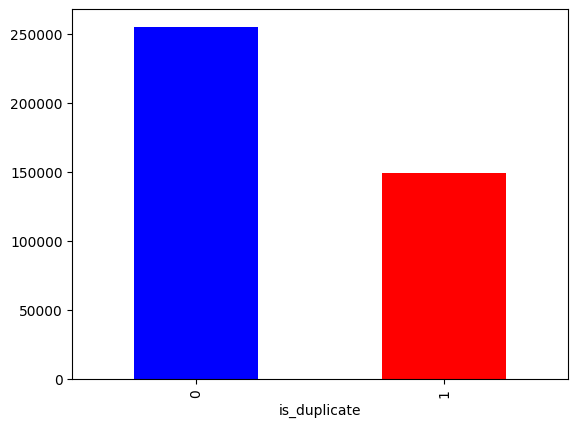

In [24]:
# Distribution of duplicate and non-duplicate question pairs
print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar', color=['blue', 'red'])

In [25]:
# unique questions
rq = pd.Series(df['qid1'].to_list() + df['qid2'].to_list())
print('Number of unique questions:', rq.unique().shape[0])

# repeated questions
rp = rq.value_counts() > 1
print('Number of repeated questions:', rp[rp].shape[0])

Number of unique questions: 537933
Number of repeated questions: 111780


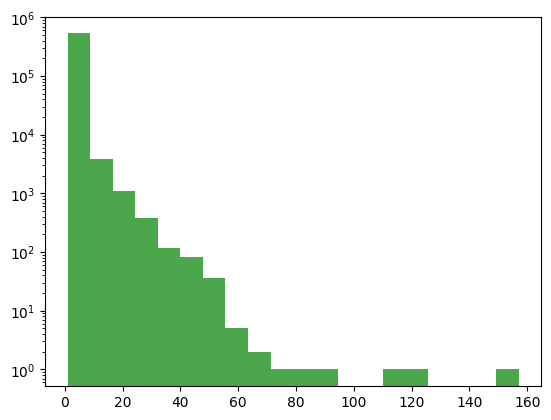

In [28]:
# Repeated questions histogram
plt.hist(rq.value_counts().values, bins=20, color='green', alpha=0.7)
plt.yscale('log')
plt.show()

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Basic text cleaning function
# This will:
# - Change text to lowercase
# - Remove HTML tags
# - Remove punctuation and numbers
# - Remove stopwords (common useless words like 'the', 'is', 'and')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()                   
    text = re.sub(r'<.*?>', '', text)              
    text = re.sub(r'[^a-z\s]', '', text)        
    tokens = text.split()                           
    tokens = [w for w in tokens if w not in stop_words] 
    return " ".join(tokens)                         

# Apply cleaning to question1 and question2
df['q1_clean'] = df['question1'].apply(clean_text)
df['q2_clean'] = df['question2'].apply(clean_text)

# See cleaned text
df[['q1_clean', 'q2_clean']].head()


,q1_clean,q2_clean
0,step step guide invest share market india,step step guide invest share market
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...
2,increase speed internet connection using vpn,internet speed increased hacking dns
3,mentally lonely solve,find remainder mathmath divided
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water


In [ ]:
# Convert text to numbers with TF-IDF
# ---------------------------------------------
# TF-IDF gives each word an importance score based on how rare it is.


vectorizer = TfidfVectorizer(max_features=3000)  

# Merge all questions into one list for training vocabulary
all_questions = pd.concat([df['q1_clean'], df['q2_clean']], axis=0)

# Fit vectorizer to ALL questions
vectorizer.fit(all_questions)

# Transform both question sets to TF-IDF vectors
q1_vec = vectorizer.transform(df['q1_clean'])
q2_vec = vectorizer.transform(df['q2_clean'])

# Combine both vectors into one big feature set
from scipy.sparse import hstack
X = hstack([q1_vec, q2_vec])  
y = df['is_duplicate']       


In [ ]:
# Split data into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train a Logistic Regression model

model = LogisticRegression(max_iter=200)  
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [ ]:
#  Make predictions & evaluate
y_pred = model.predict(X_test)

# Accuracy: How often we are correct
acc = accuracy_score(y_test, y_pred)

# F1 score: balance between precision & recall
f1 = f1_score(y_test, y_pred)

# Confusion matrix: Breakdown of predictions
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)


Accuracy: 0.7297484478963121
F1 Score: 0.5734863567162432
Confusion Matrix:
 [[44315  6488]
 [15364 14691]]


In [ ]:
# Test with your own question pair
q1 = "How can I be a good programmer?"
q2 = "What should I do to become a better designer?"

# Clean questions
q1_clean = clean_text(q1)
q2_clean = clean_text(q2)

# Convert to TF-IDF
q1_vec = vectorizer.transform([q1_clean])
q2_vec = vectorizer.transform([q2_clean])

# Combine features
test_features = hstack([q1_vec, q2_vec])

# Predict
pred = model.predict(test_features)

if pred[0] == 1:
    print("These questions are DUPLICATES.")
else:
    print("These questions are NOT duplicates.")


These questions are NOT duplicates.
